In [7]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
from IPython.display import Markdown, display
from PIL import Image
import ipywidgets as widgets

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)
from notebook_utils import load_image


In [ ]:
core = ov.Core()

model_dir = Path(r"C:\Users\sebza\OneDrive\Documentos\TEC\HACK\venv\Lib\site-packages\pytesseract")
precision = "FP16"
detection_model = "horizontal-text-detection-0001"
recognition_model = "text-recognition-resnet-fc"

model_dir.mkdir(exist_ok=True)

download_command = (
    f"omz_downloader --name {detection_model},{recognition_model} --output_dir {model_dir} --cache_dir {model_dir} --precision {precision}  --num_attempts 5"
)
display(Markdown(f"Download command: `{download_command}`"))
display(Markdown(f"Downloading {detection_model}, {recognition_model}..."))
!$download_command
display(Markdown(f"Finished downloading {detection_model}, {recognition_model}."))

detection_model_path = (model_dir / "intel/horizontal-text-detection-0001" / precision / detection_model).with_suffix(".xml")
recognition_model_path = (model_dir / "public/text-recognition-resnet-fc" / precision / recognition_model).with_suffix(".xml")


In [20]:
convert_command = f"omz_converter --name {recognition_model} --precisions {precision} --download_dir {model_dir} --output_dir {model_dir}"
display(Markdown(f"Convert command: `{convert_command}`"))
display(Markdown(f"Converting {recognition_model}..."))
! $convert_command

Convert command: `omz_converter --name text-recognition-resnet-fc --precisions FP16 --download_dir C:\Users\sebza\OneDrive\Documentos\TEC\HACK\venv\Lib\site-packages\pytesseract --output_dir C:\Users\sebza\OneDrive\Documentos\TEC\HACK\venv\Lib\site-packages\pytesseract`

Converting text-recognition-resnet-fc...

========== Converting text-recognition-resnet-fc to ONNX
Conversion to ONNX command: C:\Users\sebza\OneDrive\Documentos\TEC\HACK\venv\Scripts\python.exe -- C:\Users\sebza\OneDrive\Documentos\TEC\HACK\venv\Lib\site-packages\omz_tools\internal_scripts\pytorch_to_onnx.py --model-path=C:\Users\sebza\OneDrive\Documentos\TEC\HACK\venv\Lib\site-packages\omz_tools\models\public\text-recognition-resnet-fc --model-path=C:\Users\sebza\OneDrive\Documentos\TEC\HACK\venv\Lib\site-packages\pytesseract\public\text-recognition-resnet-fc --model-name=get_model --import-module=model "--model-param=file_config=r\"C:\Users\sebza\OneDrive\Documentos\TEC\HACK\venv\Lib\site-packages\pytesseract\public\text-recognition-resnet-fc/vedastr/configs/resnet_fc.py\"" "--model-param=weights=r\"C:\Users\sebza\OneDrive\Documentos\TEC\HACK\venv\Lib\site-packages\pytesseract\public\text-recognition-resnet-fc/vedastr/ckpt/resnet_fc.pth\"" --input-shape=1,1,32,100 --input-names=input --output-names=output --output-file=C:\U

C:\Users\sebza\OneDrive\Documentos\TEC\HACK\venv\Lib\site-packages\omz_tools\models\public\text-recognition-resnet-fc\model.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature

In [8]:
import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [14]:
core = ov.Core()
model = core.read_model(r"C:\Users\sebza\OneDrive\Documentos\TEC\HACK\venv\Lib\site-packages\pytesseract\public\text-recognition-resnet-fc\FP16\text-recognition-resnet-fc.xml")
complied_model = core.compile_model(model=model, device_name=device.value)

output_layer = complied_model.output(0)

In [15]:
detection_model = core.read_model(model=detection_model_path, weights=detection_model_path.with_suffix(".bin"))
detection_compiled_model = core.compile_model(model=detection_model, device_name=device.value)

detection_input_layer = detection_compiled_model.input(0)

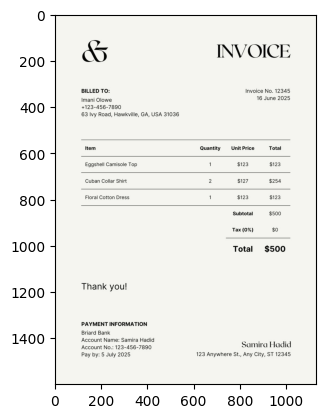

In [54]:
# The `image_file` variable can point to a URL or a local image.
image_file = r"C:\Users\sebza\Downloads\imagen_2024-09-14_213522542.png"

image = load_image(image_file)

# N,C,H,W = batch size, number of channels, height, width.
N, C, H, W = detection_input_layer.shape

# Resize the image to meet network expected input sizes.
resized_image = cv2.resize(image, (W, H))

# Reshape to the network input shape.
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

In [55]:
output_key = detection_compiled_model.output("boxes")
boxes = detection_compiled_model([input_image])[output_key]

# Remove zero only boxes.
boxes = boxes[~np.all(boxes == 0, axis=1)]

def multiply_by_ratio(ratio_x, ratio_y, box):
    return [max(shape * ratio_y, 10) if idx % 2 else shape * ratio_x for idx, shape in enumerate(box[:-1])]


def run_preprocesing_on_crop(crop, net_shape):
    temp_img = cv2.resize(crop, net_shape)
    temp_img = temp_img.reshape((1,) * 2 + temp_img.shape)
    return temp_img


def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.3, conf_labels=True):
    # Define colors for boxes and descriptions.
    colors = {"red": (255, 0, 0), "green": (0, 255, 0), "white": (255, 255, 255)}

    # Fetch image shapes to calculate a ratio.
    (real_y, real_x), (resized_y, resized_x) = image.shape[:2], resized_image.shape[:2]
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Convert the base image from BGR to RGB format.
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Iterate through non-zero boxes.
    for box, annotation in boxes:
        # Pick a confidence factor from the last place in an array.
        conf = box[-1]
        if conf > threshold:
            # Convert float to int and multiply position of each box by x and y ratio.
            (x_min, y_min, x_max, y_max) = map(int, multiply_by_ratio(ratio_x, ratio_y, box))

            # Draw a box based on the position. Parameters in the `rectangle` function are: image, start_point, end_point, color, thickness.
            cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 3)

            # Add a text to an image based on the position and confidence. Parameters in the `putText` function are: image, text, bottomleft_corner_textfield, font, font_scale, color, thickness, line_type
            if conf_labels:
                # Create a background box based on annotation length.
                (text_w, text_h), _ = cv2.getTextSize(f"{annotation}", cv2.FONT_HERSHEY_TRIPLEX, 0.8, 1)
                image_copy = rgb_image.copy()
                cv2.rectangle(
                    image_copy,
                    (x_min, y_min - text_h - 10),
                    (x_min + text_w, y_min - 10),
                    colors["white"],
                    -1,
                )
                # Add weighted image copy with white boxes under a text.
                cv2.addWeighted(image_copy, 0.4, rgb_image, 0.6, 0, rgb_image)
                cv2.putText(
                    rgb_image,
                    f"{annotation}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image

In [56]:
recognition_model = core.read_model(model=recognition_model_path, weights=recognition_model_path.with_suffix(".bin"))

recognition_compiled_model = core.compile_model(model=recognition_model, device_name=device.value)

recognition_output_layer = recognition_compiled_model.output(0)
recognition_input_layer = recognition_compiled_model.input(0)

# Get the height and width of the input layer.
_, _, H, W = recognition_input_layer.shape

In [57]:
# Calculate scale for image resizing.
(real_y, real_x), (resized_y, resized_x) = image.shape[:2], resized_image.shape[:2]
ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

# Convert the image to grayscale for the text recognition model.
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Get a dictionary to encode output, based on the model documentation.
letters = "~0123456789abcdefghijklmnopqrstuvwxyz"

# Prepare an empty list for annotations.
annotations = list()
cropped_images = list()
# fig, ax = plt.subplots(len(boxes), 1, figsize=(5,15), sharex=True, sharey=True)
# Get annotations for each crop, based on boxes given by the detection model.
for i, crop in enumerate(boxes):
    # Get coordinates on corners of a crop.
    (x_min, y_min, x_max, y_max) = map(int, multiply_by_ratio(ratio_x, ratio_y, crop))
    image_crop = run_preprocesing_on_crop(grayscale_image[y_min:y_max, x_min:x_max], (W, H))

    # Run inference with the recognition model.
    result = recognition_compiled_model([image_crop])[recognition_output_layer]

    # Squeeze the output to remove unnecessary dimension.
    recognition_results_test = np.squeeze(result)

    # Read an annotation based on probabilities from the output layer.
    annotation = list()
    for letter in recognition_results_test:
        parsed_letter = letters[letter.argmax()]

        # Returning 0 index from `argmax` signalizes an end of a string.
        if parsed_letter == letters[0]:
            break
        annotation.append(parsed_letter)
    annotations.append("".join(annotation))
    cropped_image = Image.fromarray(image[y_min:y_max, x_min:x_max])
    cropped_images.append(cropped_image)

boxes_with_annotations = list(zip(boxes, annotations))

# RESULTS

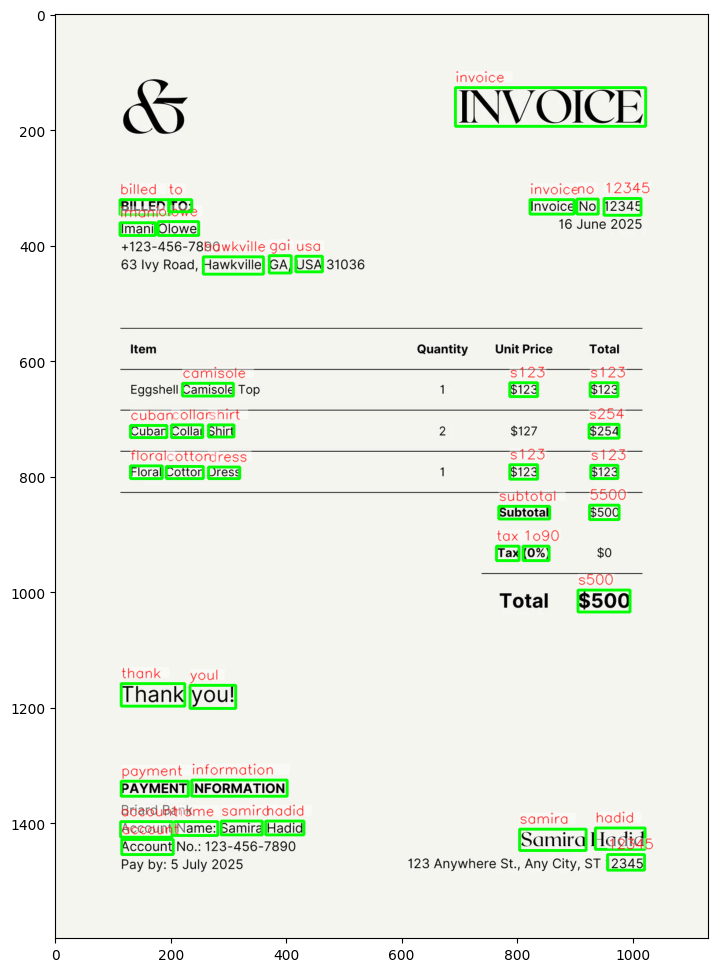

In [58]:
plt.figure(figsize=(12, 12))
plt.imshow(convert_result_to_image(image, resized_image, boxes_with_annotations, conf_labels=True));

In [61]:
[annotation for _, annotation in sorted(zip(boxes, annotations), key=lambda x: x[0][0] ** 2 + x[0][1] ** 2)]

['billed',
 'imani',
 'to',
 '723469721o',
 'olowe',
 'hawkville',
 'eggshell',
 'gai',
 'camisole',
 'usa',
 'cuban',
 'collar',
 'top',
 '31036',
 'floral',
 'shirt',
 'cotton',
 'dress',
 'invoice',
 'thank',
 'invoice',
 'youl',
 's123',
 'no',
 '5127',
 'june',
 'payment',
 's123',
 'information',
 'briard',
 'subtotal',
 '12345',
 'bank',
 '2025',
 'account',
 'tax',
 'name',
 'account',
 'samira',
 's123',
 'now',
 'pay',
 '1o90',
 '123',
 'total',
 's254',
 '4467990',
 'hadid',
 's123',
 '5500',
 's500',
 'samira',
 'hadid',
 'st',
 '12345']

In [62]:
from openai import OpenAI

texto_extraido = annotation

client = OpenAI(
    api_key="-",
    base_url="https://fridaplatform.com/v1"
)
response = client.chat.completions.create(
  model="tgi",
    messages=[
    {"role": "system", "content": "You are a financial report assistant."},
    {"role": "user", "content": f"Please generate a detailed financial report analyzing the following data. Include insights on the financial health and provide actionable recommendations for improving financial management based on the extracted information::\n\n{texto_extraido}"},
  ],max_tokens=300, stream=False
)

print(response.choices[0].message.content)

**Financial Report Analysis**

**Introduction**

This report provides an analysis of the financial data set, comprising four key figures: ['2', '0', '2', '5']. While the context of these numbers is not explicitly stated, they will be interpreted as financial metrics for the purpose of this analysis. Our objective is to extract insights into the financial health of the organization and provide actionable recommendations for improvement.

**Financial Data Analysis**

The financial data set consists of the following metrics:

* Metric 1: 2
* Metric 2: 0
* Metric 3: 2
* Metric 4: 5

**Key Observations**

1.  **Low Starting Balance**: The first metric, 2, indicates a relatively low starting balance or initial investment. This may suggest that the organization is in its early stages or has limited financial resources.
2.  **Zero Value**: The second metric, 0, implies a complete depletion of resources or a zero-value transaction. This could be a cause for concern, as it may indicate a lack of

In [36]:
import pytesseract

# Set the path to the Tesseract executable if you're on Windows
# (Skip this if Tesseract is installed and added to your PATH)
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# Load the image from file
image_path = r"C:\Users\sebza\Downloads\imagen_2024-09-14_213522542.png"
image = cv2.imread(image_path)

# Convert the image to grayscale (optional but helps with accuracy)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Use Tesseract to extract text
extracted_text = pytesseract.image_to_string(gray_image)

# Print the extracted text
print("Extracted Text:")
print(extracted_text)


Extracted Text:
INVOICE

BILLED TO:

Imani Olowe

+123-456-7890

63 Ivy Road, Hawkville, GA, USA 31036

Invoice No. 12345

16 June 2025

Item Quantity Unit Price Total
Eggshell Camisole Top 1 $123 $123
Cuban Collar Shirt 23 $127 $254
Floral Cotton Dress 1 $123 $123
Subtotal $500
Tax (0%) $0
Total $500
Thank you!

PAYMENT INFORMATION
Briard Bank

Account Name: Samira Hadid
Account No.: 123-456-7890

Samira Hadid
Pay by: 5 July 2025 123 Anywhere St., Any City, ST 12345



In [64]:
texto_extraido = extracted_text

client = OpenAI(
    api_key="-",
    base_url="https://fridaplatform.com/v1"
)
response = client.chat.completions.create(
  model="tgi",
    messages=[
    {"role": "system", "content": "You are a financial report assistant."},
    {"role": "user", "content": f"Please generate a detailed financial report analyzing the following data. Include insights on the financial health and provide actionable recommendations for improving financial management based on the extracted information::\n\n{texto_extraido}"},
  ],max_tokens=500, stream=False
)

print(response.choices[0].message.content)

**Financial Report Analysis**

**Introduction:**
This report analyzes the financial data from an invoice issued to Imani Olowe, dated June 16, 2025. The invoice details a total amount of $500 due for the purchase of clothing items. The payment information indicates that the amount should be paid to Samira Hadid via Briard Bank.

**Financial Health Analysis:**

1. **Revenue Streams:** The invoice indicates a single revenue stream from the sale of clothing items, with a total value of $500.
2. **Cost Structure:** The invoice does not provide detailed information about the cost structure or expenses related to the sale. However, we can assume that the total amount of $500 is revenue generated from the sale of these items.
3. **Profitability:** Based on the invoice, it is unclear whether the business made a profit or loss since the cost structure and expenses are not available.

**Actionable Recommendations for Improving Financial Management:**

1.  **Implement a comprehensive cost trackin